In [ ]:
import numpy as np
import scipy.stats as stats
import scipy.sparse as sparse
import itertools

#training patterns
P = 100
N=5
S=np.random.randint(0, 2, size=(P, N))*2-1

# def generateInput(beta, n, pz):
#     rvs = stats.norm().rvs
#     X = sparse.random(n, n, density=pz, data_rvs=rvs)
#     upper_X = sparse.triu(X) 
#     result = upper_X + upper_X.T - sparse.diags(X.diagonal()) - sparse.diags(X.diagonal())
#     result = result.toarray()
#     result = np.array(result) #Frustrated result
#     for i in range(n):
#       for j in range(n):
#         result[i,j] = beta * ((result[i,j]>0).astype('int') - (result[i,j]<0).astype('int'))
#     return result

def s_all(n):
  return np.array(list(itertools.product([-1, 1], repeat=n)))


# compute clamped statistics from the data (P is the amount of patterns in S)
def clamped_statistics(P,S):
  ress=0
  ss=0
  onesvec = np.ones(P)
  ress=np.dot(onesvec,S)
  for u in range(P):
    S1=np.array([S[u]])
    S2=np.array([S[u]]).T
    ss+= np.dot(S2,S1)
  ss = ss/P
  ress= ress/P
  return [ress,ss]



#not a function of S
def free_statistics(w,th,N,S):
  result=0
  # p=np.zeros([N^2])
  p=np.array([])
  s_al =s_all(N)

  # compute the probabilities of each state P(s)
  for ps in s_al:
    subresult=0
    ps=np.array(ps)
    thetaterm=np.dot(th,ps)
    wterm=np.dot(ps,np.dot(w,ps))/2
    expterm=np.exp(wterm+thetaterm)
    
    p=np.append(p,expterm)

  #normalize probabilities
  p=p/sum(p)
  # print("printing the number 1")
  # print(sum(p))
  # print(p)


 # compute the <s_i>
  ress=0
  ress1=np.zeros(N)
  iter=0
  ress=np.zeros(N)
  for ps in s_al: 
    #compute probability of outcome ps times 
    ress+=p[iter]*ps
    iter +=1
  #place result for s_i in vector
  ress1=ress

  #compute the <s_i Ss_j>
  ress2=np.ones([N,N])


  # for i in range(N):
  #   for j in range(N):
  #     iter=0
  #     ress=0
  #     for ps in s_al:
  #       ress+=p[iter]*ps[i]*ps[j]
  #       iter +=1
  #     #place result for s_i * s_j in matrix
  #     ress2[i][j]=ress

  #more effient
  ress2=np.zeros([N,N])
  iter=0
  for ps in s_al:
    #compute the matrix S : S_{ij}= (s_i*s_j)
    ps=np.array([ps])
    psmat = np.matmul(ps.T,ps)
    #add it to the total weighted by probablity
    ress2+=psmat*p[iter]
    iter+=1

  return [ress1,ress2]

A = (clamped_statistics(P,S));

theta=np.ones(N)
w=np.random.random([N,N])*2-1
#tests
#theta=np.zeros(N)
w=np.ones([N,N])


# print("free test")
# B = free_statistics(w,theta,N,S)
# print("clamped")
# print(S)
# print(A[0])
# print(A[1])
# print(B[0])
# print(B[1])



In [ ]:
def accept(p, p_new):
  a = p_new/p
  a = min(1,a)

  if np.random.binomial(1,a) == 1:
    return True
  else:
    return False

def p_dens(x, w, th):
  thetaterm=np.dot(th,x)
  wterm=np.dot(x,np.dot(w,x))/2
  return np.exp(wterm+thetaterm)

# for log likelyhood
def logp_dens(x, w, th):
  thetaterm=np.dot(th,x)
  wterm=np.dot(x,np.dot(w,x))/2
  return wterm+thetaterm


# density normalizing constant
def computnormconst(N,w,th):
  sum=0
  sall=s_all(N)
  for s in sall:
    sum+=p_dens(s,w,th)

  return sum

  #
def MH_sample(samples, w, th,returnall=False):
  s = np.random.randint(0, 2, size=(N))*2-1
  #s_hist = np.array([])
  samplesaccepted=0;
  s_hist = np.ones([samples,N])
  while samplesaccepted<samples:
    if (samplesaccepted==samples ):
      break
    
    #important !!! make copy
    new_s = s.copy()
    random_flip = np.random.randint(len(new_s))
    new_s[random_flip] = new_s[random_flip]*-1
    p_new = p_dens(new_s, w, th)
    p = p_dens(s, w, th)

    a = accept(p, p_new)

    if a:
      s = new_s
      #s_hist = np.append(s_hist, s)
      s_hist[samplesaccepted]=s;
      samplesaccepted+=1;
    #otherwise produce sample of current configuration
    else:
      s_hist[samplesaccepted]=s;
      samplesaccepted+=1;

  #return all samples for testing/plotting
  if returnall:
    return s_hist, np.mean(s_hist, axis=0) , np.cov(s_hist.T)

  #note that the sample means E[x]E[y] shoulb be added to covarance get <x_i,X_j> but the cov matrix seems to work better? TODO
  mean2=np.array([np.mean(s_hist , axis=0)])
  means2 = np.matmul(mean2.T,mean2)
  return (np.mean(s_hist , axis=0), np.cov(s_hist.T))

In [ ]:
##likelihood for likelyhood plot
def likelihood(S,w,th):
  res=1
  for x in S:
    res*=p_dens(x, w, th) 
  return res


def loglikelihood(S,w,th):
  res=0
  for x in S:
    res+=logp_dens(x, w, th) 
  return res

#normalized likelyhood
def normlikelihood(S,w,th):
  constant=computnormconst(S.shape[1],w,th)
  res=1
  print(constant)
  for x in S:
    res*=p_dens(x, w, th)/constant 
  return res


# use normlikelihood instead
def loglikelihood(S,w,th):
  return normlikelihood(S,w,th)

In [ ]:
def gradientDescent(P,N,S, rate = 0.1,tracklh=False):
  w=np.random.random([N,N])
  #maybe set diagonal of w to 0
  w = w - np.diag(w)
  theta=np.ones(N)
  maxit=10**5

  #TODO note changed for testing
  cvcrit=10**-4

  #compute clamped statistics
  clamped=clamped_statistics(P,S)

  #track likelyhoods
  lhlist=np.array([])


  dw=1000
  dtheta=1000
  for i in range(maxit):
    # print(np.linalg.norm(dw))
    # print(np.linalg.norm(dtheta))

    if tracklh:
      lhlist=np.append(lhlist,loglikelihood(S,w,theta))


    if (np.linalg.norm(dw)<cvcrit and np.linalg.norm(dtheta)<cvcrit):
      print("Converged after: {}".format(i));
      print(np.linalg.norm(dw))
      print(np.linalg.norm(dtheta))

      return  lhlist ,i,"padding",w,theta

      # break;
    wold=w
    thetaold=theta
    #break when converged

    #compute free statistics
    free=free_statistics(w,theta,N,S)

    #print(w)
    #print(theta)
    #print(clamped[1])
    #print(free[1])
    #print(clamped[0])
    #print(free[0])

    w=w+rate*(clamped[1]-free[1])
    theta=theta+rate*(clamped[0]-free[0])

    dw=w-wold 
    # if i%1000 ==0:
    # print(np.linalg.norm(dw))
    # print(np.linalg.norm(dtheta))
    dtheta=theta-thetaold
    #print(np.linalg.norm(dtheta))

# print(S)
#gradientDescent(P,N,S)

In [ ]:
#plots of likelihood
#



#Patterns Test

In [ ]:
# P_range = np.linspace(10.0, 210.0, num=9)
# iteration_values = []
# for P in P_range:
#   N=5
#   S=np.random.randint(0, 2, size=(int(P), N))*2-1
#   iteration_values.append(gradientDescent(int(P),N,S))
  

In [ ]:
import matplotlib.pyplot as plt

# plt.plot(P_range, iteration_values)
# plt.ylabel('Iterations')
# plt.xlabel('Patterns')
# plt.show()

#SALAMANDER

In [ ]:
# Salamander_data = np.loadtxt('bint.txt', unpack = True, dtype=int)
import pandas as pd
import random

#pick random sample 
val = random.randrange(0, (283041-953), 953)	
skiprows = random.randint(0, 80)	
print(val)
print(skiprows)

data = pd.read_csv('bint.txt', sep=" ",usecols=range(0,953),  header=None, nrows = 10)

#data = pd.read_csv('bint.txt', sep=" ", usecols=range(val, val+953), header=None, nrows = 10, skiprows = skiprows)

269699
42


In [ ]:
print(data)
data = np.array(data)
data = data *2-1
print(data.shape)
print(data)

   0    1    2    3    4    5    6    7    8    9    ...  943  944  945  946  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    1    0    0    0    1    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
5    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
6    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
7    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
8    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
9    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   947  948  949  950  951  952  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0 

In [ ]:
sol = gradientDescent(953,10,data.T, 0.01, tracklh = True)

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
print(sol)
exactlikely=sol[1]

plt.plot(exactlikely)
plt.xlabel('Iterations')
plt.ylabel('log likelihood')
plt.title('Salamander dataset log likelihood over iterations')
plt.show()

NameError: ignored

# Metropalis Hasting

In [ ]:
#MH plots and tests
N=5
w=np.random.random([N,N])
th=np.random.random(N)
res= MH_sample(1000,w,th,True)
#res2= MH_sample(100,w,th)
#print(res[0])
print(res[1])
#print(res[2])

samples = 1000
print(free_statistics(w,th,N,S)[0])
print(MH_sample(samples,w,th)[0])
print(MH_sample(samples,w,th)[0])
print(MH_sample(samples,w,th)[0])
print(MH_sample(samples,w,th)[0])

likelihood(S,w,th)


[0.842 0.834 0.85  0.922 0.89 ]
[0.89883326 0.92862298 0.92346961 0.93871121 0.92933159]
[0.94  0.97  0.944 0.994 0.97 ]
[0.916 0.922 0.918 0.934 0.924]
[0.954 0.894 0.994 0.998 0.988]
[0.614 0.644 0.658 0.636 0.598]


5.724226761192443e+33

In [ ]:
# gradient descent using metropolis hasting
def gradientDescent_MH(P,N,S, steps,computelh=False,computeexact=False):
  w=np.random.random([N,N])
  #maybe set diagonal of w to 0
  w = w - np.diag(w)
  theta=np.ones(N)
  brate=0.1 #base rate for variable learn rate
  rate=0.1
  maxit=10**5

  #compute clamped statistics
  clamped=clamped_statistics(P,S)


  #likelihood plot
  likelihoodplot=np.array([])
  #gradient error
  gerror1=np.array([])
  gerror2=np.array([])  

  dw=1000
  dtheta=1000
  for i in range(maxit):
    # print(np.linalg.norm(dw))
    # print(np.linalg.norm(dtheta))
    if (np.linalg.norm(dw)<10**(-5) and np.linalg.norm(dtheta)< 10**(-5)):
      print("Converged after: {}".format(i));
      print(np.linalg.norm(dw))
      print(np.linalg.norm(dtheta))
      print(dw)
      print(dtheta)

      if computelh:
        return likelihoodplot,gerror1,gerror2,w,theta
      return i

      # break;

    #compute likelyhood
    if computelh:
      likelihoodplot=np.append(likelihoodplot,likelihood(S,w,theta))

    wold=w
    thetaold=theta
    #break when converged

    #compute free statistics
    free= MH_sample(steps, w, theta)
    #compute exact for comparison
    if computeexact:
      exact=free_statistics(w,theta,N,S)
      gerror1=np.append(gerror1,np.linalg.norm(free[0]-exact[0]))
      gerror2=np.append(gerror2,np.linalg.norm(free[1]-exact[1]))
    #print(free[0]-clamped[0])
    #print(clamped[0])
    #print(w)
    #print(theta)
    #print(clamped[1])
    #print(free[1])
    #print(clamped[0])
    #print(free[0])

    w=w+rate*(clamped[1]-free[1])
    theta=theta+rate*(clamped[0]-free[0])

    dw=w-wold 
    #print(np.linalg.norm(dw)/rate)
    dtheta=theta-thetaold
    #print(np.linalg.norm(dtheta)/rate)
    #print(rate)

    #make rate scale with difference
    rate=(np.linalg.norm(dw)/rate+np.linalg.norm(dtheta)/rate)*brate
    #make rate decrease with time and exponentially with time (choices are experimental)
    brate*=(0.98)
    #brate*=(0.9999)**i
    #brate*=(0.9999)**(i^2)
    #print(rate)

# print(S)


N=5
P=10
S=np.random.randint(0, 2, size=(int(P), N))*2-1
#gradientDescent_MH(P,N,S, 1000)

Experiments for MH

In [ ]:
#experiments
N=5
P=20
S=np.random.randint(0, 2, size=(int(P), N))*2-1

gdexact=gradientDescent(P,N,S,0.1,True)
gdlh=gradientDescent_MH(P,N,S, 100,True,True)

Converged after: 3982
9.999831550872281e-05
9.89325417088733e-05
Converged after: 434
9.803007370375363e-06
7.119541506434327e-06
[[ 2.75814388e-06 -1.70742240e-06 -4.47787942e-06  7.83936727e-07
  -2.15890428e-06]
 [-1.70742240e-06  2.45441970e-06 -8.90650627e-07  1.79361440e-06
   8.94755007e-07]
 [-4.47787942e-06 -8.90650627e-07  3.20141700e-07  9.11172530e-07
  -1.51862088e-07]
 [ 7.83936727e-07  1.79361440e-06  9.11172531e-07  1.97010277e-07
   3.98124934e-07]
 [-2.15890428e-06  8.94755007e-07 -1.51862088e-07  3.98124935e-07
   3.76782154e-06]]
[-2.43800218e-06  5.28233805e-06 -8.12667392e-07  2.84433587e-06
 -2.84433587e-06]


In [ ]:
#sampling vs exact solution experiments

N=5
w=np.random.random([N,N])
th=np.random.random(N)
#sampling solution
A=MH_sample(samples, w, th,returnall=False)
#exact solution
B=free_statistics(w,th,N,S)
result=A[0]
mean,cov = np.mean(result , axis=0), np.cov(result.T)
mean2=np.array([mean])
means2 = np.matmul(mean2.T,mean2)
#print(cov+means2)
#print(mean)
# print(A[0])
# print(B[0])
# print(A[1])
# print(B[1])



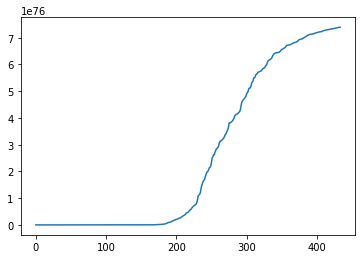

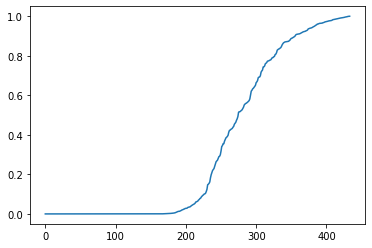

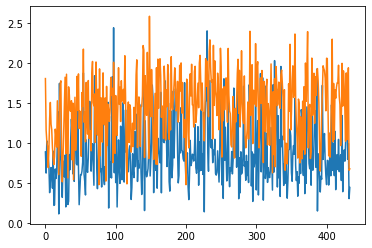

In [ ]:

#likelyhood plots
import matplotlib.pyplot as plt
exactlikely=gdexact[1]
likely=gdlh[0]
errors1=gdlh[1]
errors2=gdlh[2]
gdlhnorm=likely/np.max(likely)

#normalized likelyhood
plt.plot(likely)

plt.plot(exactlikely)
plt.show()
plt.plot(gdlhnorm)
plt.show()
plt.plot(errors1)
plt.plot(errors2)

In [ ]:
#exact solution from fixed point equations

#epsilon for diagonal
def directsol(S,epsilon=0.001):




  P=S.shape[0]
  N=S.shape[1]

  clamped=clamped_statistics(P,S)
  C=clamped[1]
  means=clamped[0]
  means=np.array([means])
  meansprod = np.matmul(means.T,means)
  #subtract the products <s_i><s_j>
  C=C-meansprod

  #add epsilon
  diag=np.diag(np.ones(N))*epsilon
  C=C+diag

  cinv = np.linalg.inv(C)
  #print(cinv)
  #print(clamped[0])
  deltaterm = np.diag(1/(1-clamped[0]**2))
  w = deltaterm-cinv

  theta = np.tanh(clamped[0])- w @ clamped[0]
  return "filler","filler","filler",w,theta


Text(0, 0.5, 'likelihood of S')

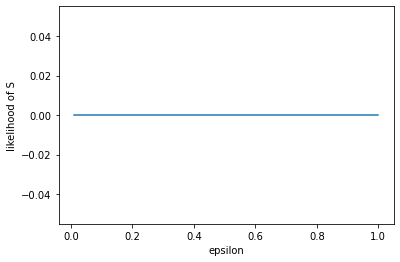

In [ ]:
#direct sol experiments with epsilon
N=5
P=90
S=np.random.randint(0, 2, size=(int(P), N))*2-1

#salamander data test
S=data.T
N=data.shape[0]
P=data.shape[1]



def direcsolexp(S):
  toplot=np.array([])
  epsilons = (np.array(range(100))+1)*0.01
  for epsilon in epsilons:
    a,b,c,w,th = directsol(S,epsilon)
    toplot=np.append(toplot,normlikelihood(S,w,th))

  return toplot,epsilons

epsilonsols , epsilons =direcsolexp(S)
plt.plot(epsilons,epsilonsols)
plt.xlabel("epsilon")
plt.ylabel("likelihood of S")

In [ ]:
#MF_approx
def mf_approx(w,theta,smoothing=0.5):

  #initialize
  m=np.random.rand(N)
  dm=1

  #iterate
  for i in range(100000):
    temp=np.dot(w,m)
    temp2=temp+theta
    mprime=np.tanh(temp2)
    newm=smoothing*m+(1-smoothing)*mprime
    dm=np.max(np.abs(newm-m))
    m=newm
    if dm<10**(-13):
      break;
  m_mf=m
  return [m_mf,i]

#computes <s_i s_j>-<s_i> <s_j>
def xiLR(m,w,n):
  A=np.ones([n,n])
  for i in range(n):
    for j in range(n):
      if(i==j):
        A[i][j]=1/(1-m[i]**2)-w[i][j]
      else: #delta fucntion ? maybe something else
        A[i][j]=-w[i][j]

  Ainv=np.linalg.inv(A)
  return Ainv

# use this one to replace free_statistics()
def mf_approx_statistics(w,theta,smoothing=0.5):
  res= mf_approx(w,theta,smoothing=0.5)
  #<s_i>
  m=res[0]
  m2=np.array([m])
  #<s_i><s_j>
  covm = np.matmul(m2.T,m2)
  #<s_i s_j> - <s_i> <s_j>
  xi=xiLR(m,w,N)
  stat1=m
  stat2=xi+covm

  return stat1,stat2


mf_approx_statistics(w,theta,smoothing=0.5)



(array([0.99772053, 0.99568012, 0.99908788, 0.99934723, 0.99463948]),
 array([[1.00001555, 0.99342787, 0.9968122 , 0.99707195, 0.99240014],
        [0.99343903, 1.00001029, 0.99478592, 0.99503348, 0.9903464 ],
        [0.99681833, 0.99477778, 1.00000313, 0.99843652, 0.99373783],
        [0.99707475, 0.99503519, 0.99843761, 1.00000143, 0.9939907 ],
        [0.99239194, 0.99035789, 0.99374696, 0.9939963 , 1.00002526]]))

In [ ]:
#gradient descent using MF approximation
def gradientDescent_MF(P,N,S,computelh=False,computeexact=False):
  w=np.random.random([N,N])
  #maybe set diagonal of w to 0
  w = w - np.diag(w)
  theta=np.ones(N)
  brate=0.1 #base rate for variable learn rate
  rate=0.1
  maxit=10**5

  #compute clamped statistics
  clamped=clamped_statistics(P,S)


  #likelihood plot
  likelihoodplot=np.array([])
  #gradient error
  gerror1=np.array([])
  gerror2=np.array([])  

  dw=1000
  dtheta=1000
  for i in range(maxit):
    # print(np.linalg.norm(dw))
    # print(np.linalg.norm(dtheta))
    if (np.linalg.norm(dw)<10**(-5) and np.linalg.norm(dtheta)< 10**(-5)):
      print("Converged after: {}".format(i));
      print(np.linalg.norm(dw))
      print(np.linalg.norm(dtheta))
      print(dw)
      print(dtheta)

      if computelh:
        return likelihoodplot,gerror1,gerror2,w,theta
      return i

      # break;

    #compute likelyhood (normalized)
    if computelh:
      likelihoodplot=np.append(likelihoodplot,normlikelihood(S,w,theta))

    wold=w
    thetaold=theta
    #break when converged

    #compute free statistics
    free= mf_approx_statistics(w,theta)
    #compute exact for comparison
    if computeexact:
      exact=free_statistics(w,theta,N,S)
      gerror1=np.append(gerror1,np.linalg.norm(free[0]-exact[0]))
      gerror2=np.append(gerror2,np.linalg.norm(free[1]-exact[1]))
    #print(free[0]-clamped[0])
    #print(clamped[0])
    #print(w)
    #print(theta)
    #print(clamped[1])
    #print(free[1])
    #print(clamped[0])
    #print(free[0])

    w=w+rate*(clamped[1]-free[1])
    theta=theta+rate*(clamped[0]-free[0])

    dw=w-wold 
    #print(np.linalg.norm(dw)/rate)
    dtheta=theta-thetaold
    #print(np.linalg.norm(dtheta)/rate)
    #print(rate)

    #make rate scale with difference
    rate=(np.linalg.norm(dw)/rate+np.linalg.norm(dtheta)/rate)*brate
    #make rate decrease with time and exponentially with time (choices are experimental)
    brate*=(0.98)
    #brate*=(0.9999)**i
    #brate*=(0.9999)**(i^2)
    #print(rate)

# print(S)


N=5
P=10
S=np.random.randint(0, 2, size=(int(P), N))*2-1
S=np.random.randint(0, 2, size=(int(P), N))*2-1


In [ ]:
#MF approx descent test
N=5
P=50
S=np.random.randint(0, 2, size=(int(P), N))*2-1
mfgd = gradientDescent_MF(P,N,S, True)


Converged after: 299
9.821362012988645e-06
7.394334630113101e-06
[[-9.91991642e-07  3.10967235e-06 -2.53550957e-06  8.15205839e-07
   2.33754845e-06]
 [ 2.14855245e-06  3.87462663e-07  9.43576813e-07  9.90029395e-07
   1.44047215e-06]
 [ 4.94674076e-07  3.03225558e-06 -1.65753029e-06  1.15711245e-06
   2.21581285e-06]
 [ 3.66004547e-06  2.77200886e-06 -1.16973858e-07 -2.51572446e-07
   2.86946880e-06]
 [ 2.64097662e-06  2.41666874e-06 -5.90310480e-07  8.74014957e-07
   1.66795036e-06]]
[-2.49739950e-06 -1.58897705e-06 -4.15851252e-06 -3.90028713e-06
 -3.66181188e-06]


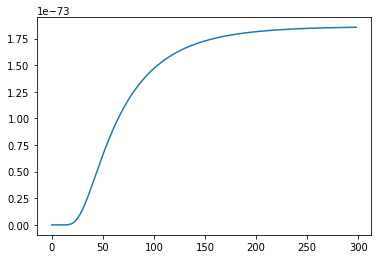

In [ ]:
#likelyhood plot for MF approx
import matplotlib.pyplot as plt
plt.plot(mfgd[0])

In [ ]:

#plot of frequences and likelyhood
import matplotlib.pyplot as plt
from collections import Counter

title="MF_approx "


# makes plot with title, for dataset S, with results mfgd
def plot_likely(title,S,mfgd):
  plt.plot(mfgd[0])
  plt.xlabel("iterations")
  plt.ylabel("likelihood")
  plt.title(title + " likelihood over iterations")
  plt.show()

def make_plots(title,S,mfgd):
  sall=s_all(S.shape[1])
  w=mfgd[3]
  th=mfgd[4]


  # count occurences
  counter = Counter(map(tuple, S))

  # pairs of densities and rates
  pairs = []

  # apply some normalization if needed to prevent exponents becommming to large
  meanw=np.mean(w)
  meanth=np.mean(th)
  if(np.absolute(meanw)>2 or np.absolute(meanth)>2):
    w= w/(np.absolute(meanw) + np.absolute(meanth))
    th=th/(np.absolute(meanw) + np.absolute(meanth))



  for s in sall:
    a=p_dens(s,w,th)
    b=counter[tuple(s)]
    pairs.append(np.array([a,b]))
  totals=sum(pairs)
  frequencies=[]
  for pair in pairs:
    a=pair[0]/totals[0]
    b=pair[1]/totals[1]


    frequencies.append([a,b])

  # turn into np array for transpsing
  frequencies=np.array(frequencies).T
  plt.scatter(frequencies[1],frequencies[0])
  plt.ylabel("theoretical pattern rate")
  plt.xlabel("observed pattern rate")
  plt.title(title+ " pattern rates")

  #add diagonal
  plt.plot([0, 0.1], [0, 0.1])


  #set logarithmic scale
  #plt.yscale("log")
  #plt.xscale("log")
  #plt.xlim([10**-4, 10**2])
  #plt.ylim([10**-10, 10**2])
  plt.show()

#make_plots(title,S,resultMF_approx)
#make_plots(title,S,resultExact)


SALAMANDER DATA SET TESTS

In [ ]:
#salamander data test
S=data.T
N=data.shape[0]
P=data.shape[1]
# direct solution from equation
salresultdirect = directsol(S)




In [ ]:
# gradient descent using MF approx
salresultMF_approx = gradientDescent_MF(P,N,S, True)

In [ ]:
# result from gradient descent using MH sampling
salresultsample = gradientDescent_MH(P,N,S, 10**2,computelh=True,computeexact=False)

In [ ]:
# result from gradient descent using exact computation of statistics
salresultExact=gradientDescent(P,N,S, rate = 0.1,tracklh=True)

In [ ]:
#try all methods for same data


#random dataset
N=5
P=90
S=np.random.randint(0, 2, size=(int(P), N))*2-1


# direct solution from equation
resultdirect = directsol(S)

# gradient descent using MF approx
resultMF_approx = gradientDescent_MF(P,N,S, True)

# result from gradient descent using MH sampling
resultsample = gradientDescent_MH(P,N,S, 10**2,computelh=True,computeexact=False)

# result from gradient descent using exact computation of statistics
resultExact=gradientDescent(P,N,S, rate = 0.1,tracklh=True)



Converged after: 335
9.823266378258654e-06
6.85935972625158e-06
[[-7.27361747e-07  3.13739179e-06  2.61287523e-06  1.77192399e-06
   3.70437646e-06]
 [ 3.78721838e-07  4.48941003e-07  2.24572928e-06  1.67401050e-06
   2.49355307e-06]
 [-1.51644972e-08  2.05601017e-06  6.28624690e-07  1.45582485e-06
   2.56600099e-06]
 [ 2.94526721e-07  2.72827208e-06  1.94153747e-06  6.55530294e-07
   2.94617387e-06]
 [ 3.86486287e-08  1.87671681e-06  2.13252315e-06  1.52676997e-06
   1.97195315e-06]]
[-3.84759040e-06 -2.31064254e-06 -2.71954583e-06 -3.25625923e-06
 -2.98473472e-06]
Converged after: 413
8.717369498695741e-06
9.884498082781526e-06
[[ 2.35504129e-06  2.20538984e-06  1.09481853e-06 -2.21326623e-06
   2.46531078e-06]
 [ 2.20538984e-06  0.00000000e+00 -1.85095218e-06 -5.51347459e-07
  -1.85095218e-06]
 [ 1.09481853e-06 -1.85095218e-06  1.13420049e-06 -1.18933523e-06
   2.74098451e-06]
 [-2.21326623e-06 -5.51347459e-07 -1.18933523e-06  9.37290680e-07
  -1.00030182e-06]
 [ 2.46531078e-06 -1.8

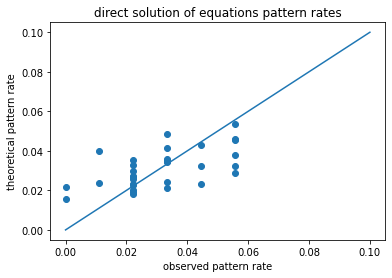

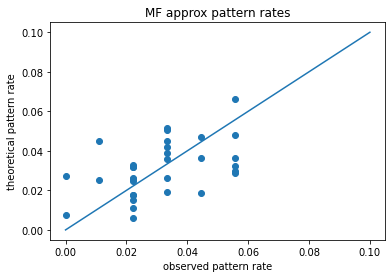

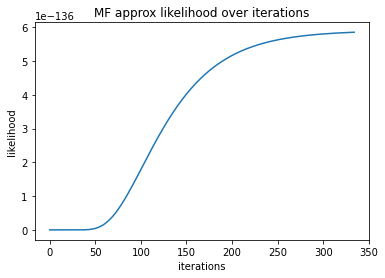

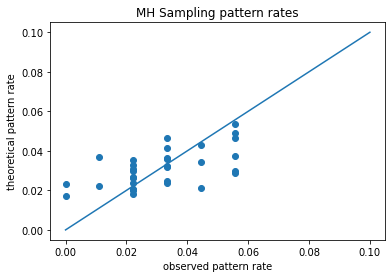

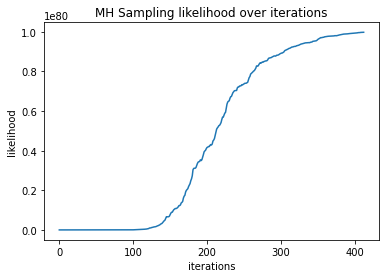

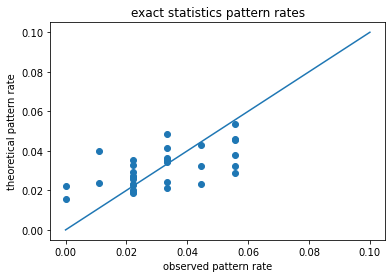

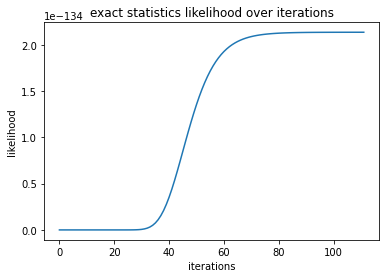

In [ ]:
#plot the above data
make_plots("direct solution of equations",S,resultdirect)

make_plots("MF approx",S,resultMF_approx)
plot_likely("MF approx",S,resultMF_approx)

make_plots("MH Sampling",S,resultsample)
plot_likely("MH Sampling",S,resultsample)

make_plots("exact statistics",S,resultExact)
plot_likely("exact statistics",S,resultExact)




In [ ]:
#plot the data for the salamander set
make_plots("direct solution of equations",S,salresultdirect)

make_plots("MF approx",S,salresultMF_approx)
plot_likely("MF approx",S,salresultMF_approx)

make_plots("MH Sampling",S,salresultsample)
plot_likely("MH Sampling",S,salresultsample)


#make_plots("exact computation of statistics",S,salresultExact)
#plot_likely("exact computation of statistics",S,salresultExact)